In [1]:
# !pip install --user faker

In [2]:
from PIL import Image, ImageOps, ImageFilter, ImageChops
from IPython import display
import random

IMG = Image.open('./judgement2.jpg')

def random_image(img=IMG, size=(200, 100)):
    width, height = size
    sqrt2 = 2 ** .5
    regionsize = int(min(
        max(width, height) * sqrt2,
        min(img.size),
    ))
    inscribed = int(regionsize / sqrt2)
    x = random.randint(0, img.width - regionsize)
    y = random.randint(0, img.height - regionsize)
    subsection = img.crop([x, y, x+regionsize, y+regionsize])
    angle = random.randint(0, 360)
    rotated = subsection.rotate(angle)
    cropbox = [
    ]
    ratio = width / height
    if ratio > 1:
        cw, ch = inscribed, inscribed / ratio 
    else:
        cw, ch = inscribed * ratio, inscribed
    cropbox = (
        (regionsize-cw)/2, 
        (regionsize-ch)/2,
        (regionsize+cw)/2,
        (regionsize+ch)/2,
    )
    cropped = rotated.crop(cropbox)
    blur = ImageFilter.GaussianBlur(1)
    result = cropped.resize((width, height))
    enhanced = result.filter(blur)
    enhanced = random_bands(enhanced)
    blended = ImageChops.blend(result, enhanced, 0.5)
    blended = ImageChops.blend(blended, ImageOps.equalize(blended), 0.5)
    blended = blended.filter(blur)
    #blended =  ImageOps.equalize(blended)
    return blended 

def random_bands(img):
    r,g,b = img.split()
    bands = [r,g,b]
    dice = [True] * 2 + [False] * 3 
    random.shuffle(dice)
    if dice.pop():
        random.shuffle(bands)
    negbands = (ImageChops.invert(b) for b in bands)
    bands = [n if d else b for (b, n, d) in zip(bands, negbands, dice)]
    newimg = Image.merge('RGB', bands)
    newimg = ImageOps.equalize(newimg)
    return newimg



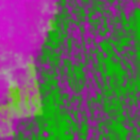
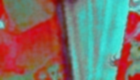
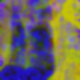
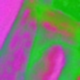
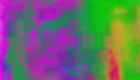
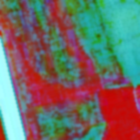
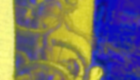
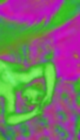
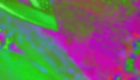
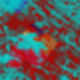
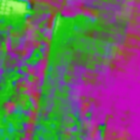
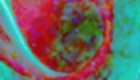
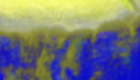
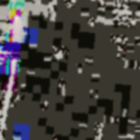
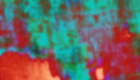
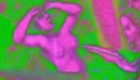
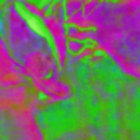
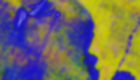
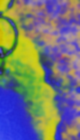
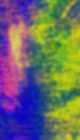
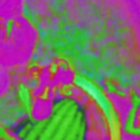
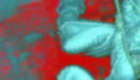
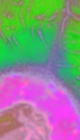
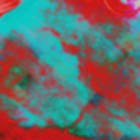
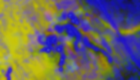
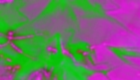
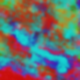
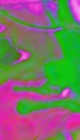
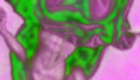
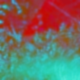
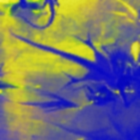
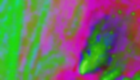
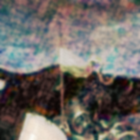
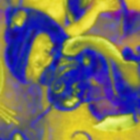
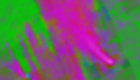
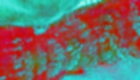
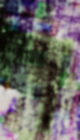
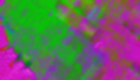
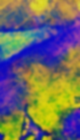
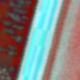
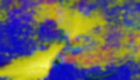
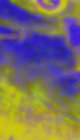
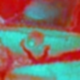
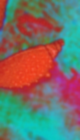
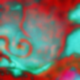
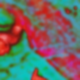
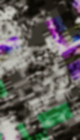
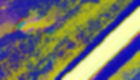
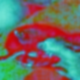
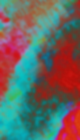

In [3]:
from io import BytesIO
import base64

def data_url(image):
    b = BytesIO()
    image.convert('RGB').save(b, 'PNG')
    raw = b.getvalue()
    data = base64.encodebytes(raw).decode('ascii').replace('\n', '')
    return 'data:image/png/;base64,{}'.format(data)

def image_to_html_img(image, style={}, **attrs):
    attrs['style'] = '{}'.format(';'.join('{}: {}'.format(*item) for item in style.items()))
    attrs['src'] = data_url(image)
    html = '<img {} />'.format(' '.join('{}="{}"'.format(*item) for item in attrs.items()))
    return html

def make_images(n=1, in_range=range(200,500,100)):
    choice = lambda: random.choice(in_range)
    images = (random_image(size=(choice(), choice())) for _ in range(n))
    style = {'display': 'inline-block', 'margin': '2px'}
    html = ''.join(image_to_html_img(img, style, title=img.size) for img in images)
    return display.HTML(html)

make_images(50, range(80, 200, 60))

In [4]:
from django.core.files import File
from faker import Factory
FAKE = Factory.create('no')

def fake_imagefile(size=(1200, 600), class_=ImageFile, fake=FAKE, **kwargs):
    image = random_image(size=size)
    blob = BytesIO()
    image.convert('RGB').save(blob, 'JPEG')
    filename = kwargs.pop('filename', fake.file_name(extension='jpg'))
    instance = class_(**kwargs)
    content = File(blob)
    instance.source_file.save(filename, content)
    return instance

def fake_contributor(fake=FAKE, **kwargs):
    name = fake.name()
    filename = '{}.jpg'.format(name).lower()
    byline_photo = fake_imagefile((400,400), ProfileImage, filename=filename)
    instance = Contributor(
        byline_photo = byline_photo,
        display_name = name,
        phone = fake.phone_number(),
        email = fake.email(),
        verified = True,
    )
    instance.save()
    return instance

In [5]:
def fake_story_image(story, byline):
    imagefile = fake_imagefile(contributor=byline)
    instance = StoryImage(
        parent_story = story,
        caption = 'foobar',
        imagefile = imagefile,
    )
    instance.save()
    return instance

In [6]:
def random_contributor():
    try:
        return Contributor.objects.order_by('?').first()
    except Contributor.DoesNotExist:
        fake_contributor()

def random_storytype():
    return StoryType.objects.order_by('?').first()

def fake_story_content(fake=FAKE):
    sections = "@tit:{title}", "@ing:{lede}", "@txt:{content}"
    title = fake.sentence(random.choice([1,2,3]))
    lede = ' '.join(fake.sentences(random.choice([1,2,3])))
    content = '\n'.join(fake.paragraphs(random.choice([4,5,10,20,30])))
    return '\n'.join(sections).format(title=title, lede=lede, content=content)


def fake_story():
    photo_by = random_contributor()
    text_by = random_contributor()
    markup = '{}\n@bl: text: {}\n@bl: photo:{}'.format(
        fake_story_content(), text_by, photo_by)
    
    print(markup)
    
    story = Story(
        story_type=random_storytype(),
        bodytext_markup=markup,
        publication_status = Story.STATUS_PUBLISHED,
        publication_date = timezone.now(),
    )
    story.save()
    numphotos = random.choice([0,1,1,3,5])
    for _ in range(numphotos):
        fake_story_image(story, photo_by)
    story.refresh_from_db()
    story.full_clean()
    story.frontpagestory_set.all().delete()
    story.save(new=True)
    return story

fake_story()

@tit:Quisquam recusandae iste.
@ing:Porro nemo eligendi velit eum. Modi unde impedit asperiores expedita facere. Saepe animi quaerat fugiat optio autem consequatur.
@txt:Nulla voluptatibus reprehenderit veniam fuga. Autem hic architecto eius quae soluta.
Quos nisi illum maxime vel eligendi. Quae corrupti ipsa explicabo nihil excepturi. Nam ex eius harum ipsam modi velit.
Cumque deleniti libero soluta quam dignissimos. Natus fugit architecto deleniti laudantium. Nostrum similique cupiditate unde deserunt ipsum. Ipsam iure maxime natus exercitationem aliquid.
Consequatur fuga consequatur consectetur ex quasi. Dolorem ratione nemo dolores rem. Explicabo labore possimus doloribus id explicabo inventore numquam. Id ut voluptate labore quo inventore.
Doloremque ratione labore minus eos similique consectetur modi. Quas quisquam accusantium odio. Perspiciatis a sequi quasi reprehenderit voluptatem asperiores dolor. Quisquam quas omnis minima totam voluptate necessitatibus.
Nemo consequuntur cu

20:49:12 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

20:49:15 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)



<Story: 2017-02-13: Quisquam recusandae iste.>

In [7]:
Story.objects.all().delete()
Contributor.objects.all().delete()
[print(fake_contributor()) for n in range(20)]
[print(fake_story()) for n in range(50)]

Rita Knutsen
Torbjørn Solberg
Kenneth Edvardsen
Andreas Aas
Frank Hauge-Johannessen
Øyvind Haugen
Sverre Halvorsen
Petter-Kjetil Bakke
Lars Jenssen
Stig Brekke
Camilla-Linn Edvardsen
Grete Paulsen
Thomas Sæther
Trine Ali
Prof. Joakim Lunde
Joakim-Tobias Nilsen
Tonje Nygård-Moe
Sigrid Eide-Engen
Torbjørn Myklebust
Dr. Ola Andresen
@tit:Laboriosam provident eos voluptatem quis.
@ing:Eum quidem eveniet quos.
@txt:Porro repudiandae quod numquam. Veniam incidunt magnam nulla architecto. Soluta neque dolore ea quisquam.
Dignissimos a a placeat temporibus. Culpa laudantium assumenda deserunt molestiae sed quae iste mollitia. At quia est iusto ullam recusandae.
Velit rem repudiandae odit quibusdam atque. Cum libero voluptate sint ducimus neque. In perferendis ipsa omnis non. Occaecati occaecati reiciendis sunt omnis perferendis. Tenetur doloremque consequatur quibusdam vero.
Quis exercitationem dolorum voluptate nemo facilis rem sint. Enim quasi expedita est vero qui odio. Voluptatum odio volu

20:49:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Laboriosam provident eos voluptatem quis.
@tit:Voluptatibus corrupti veritatis.
@ing:Mollitia omnis mollitia accusamus. Quisquam qui deserunt mollitia fuga totam ab. Fugit nam eos tempore necessitatibus voluptatem.
@txt:Voluptatem alias mollitia sunt aliquam explicabo. Deserunt atque velit quasi rem cum sequi. Quia quis culpa maxime architecto architecto nemo suscipit cupiditate. Expedita architecto quod cupiditate ducimus culpa.
Tempore excepturi libero laborum. Quisquam debitis quod tempore aliquam. Tempora eveniet a facilis tenetur cupiditate quam sint.
Quae aliquam iusto quasi maiores ratione eius. Enim a aperiam rerum. Numquam accusantium quam culpa dignissimos. Aliquam dignissimos quos nam omnis aliquam libero dolorem natus.
Pariatur officia repellendus commodi sit laboriosam. Corrupti commodi accusantium consectetur corrupti ipsam doloribus molestiae. Aperiam similique veniam quaerat.
@bl: text: Petter-Kjetil Bakke
@bl: photo:Thomas Sæther


20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 2)

20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Voluptatibus corrupti veritatis.
@tit:Aliquid quod odit excepturi.
@ing:Quisquam eius voluptatibus consectetur iste aut.
@txt:Earum sit aut nisi cumque. Quam sit dolores eveniet velit ipsa earum accusamus consequuntur. Deleniti ratione accusantium laudantium nesciunt libero ipsa maiores.
Architecto sint accusamus et ipsum qui aliquid magni. Accusantium earum eius ex voluptatibus fuga. Repellat culpa cupiditate eius tempora distinctio minima. Repudiandae molestias perspiciatis rem inventore enim magni.
Rerum hic repellat quidem pariatur deleniti neque. Hic et qui distinctio officiis. Nemo possimus fugiat ex porro repudiandae. Adipisci nulla repudiandae provident deserunt possimus placeat.
Adipisci fugit quia commodi hic. Repellat similique vero quibusdam enim possimus optio labore temporibus. Nulla laudantium ab ut possimus magnam in id excepturi.
@bl: text: Joakim-Tobias Nilsen
@bl: photo:Torbjørn Solberg


20:49:40 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Aliquid quod odit excepturi.
@tit:Debitis commodi ducimus.
@ing:Facilis repellendus totam incidunt dolorem.
@txt:Eum qui molestias unde error autem incidunt tempore. Cumque ipsa tempora quo nam. Inventore quaerat veniam laboriosam debitis sequi. Ducimus dolorem aperiam reiciendis esse porro voluptatibus consequuntur.
Vitae odit maxime et. Quisquam ea nemo fugiat omnis voluptatem nostrum. Sunt in id sunt ipsa sit vitae. Consequatur et quibusdam eius quibusdam.
Dolore fuga reprehenderit maxime possimus necessitatibus. Magni hic placeat odit necessitatibus accusamus. Commodi totam excepturi praesentium culpa quia ab molestias. Eaque recusandae deserunt iusto sequi quam eum.
Dolore natus vitae veritatis neque consequuntur. Placeat quos voluptatibus eos. Animi debitis illum delectus consequuntur non iure. Quae reiciendis illo ullam voluptatum assumenda architecto.
Placeat et natus vel dignissimos. Architecto porro numquam ea fugit tempore magni illum. Iure laborum aspernatur vel

20:49:41 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)

20:49:42 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Debitis commodi ducimus.
@tit:Error reiciendis.
@ing:Nisi porro nam ab eveniet. Sint sint minima rem repellat ducimus labore perspiciatis. Veniam excepturi numquam pariatur reprehenderit non laudantium dignissimos.
@txt:Accusantium eaque adipisci maiores veniam veritatis velit possimus. Alias laborum explicabo natus qui corporis. Deleniti dolores ex rerum dolor cupiditate ipsam dignissimos. Veniam dolor vero in voluptate optio optio.
Aut maiores maxime reiciendis nemo maxime illum. Totam accusantium recusandae enim culpa excepturi molestias ab. Ipsum illum cumque quam officia.
Ut temporibus esse vel occaecati deserunt sint. Velit iusto dolore autem ad velit porro officia. Excepturi officia fugiat doloribus ducimus laboriosam fugit officia. Ducimus qui quidem maxime. Repellat animi qui fuga eveniet dolore quia possimus.
Aliquam unde quidem odit doloremque sequi quasi. Id accusamus similique impedit libero incidunt pariatur officiis. Tempore tenetur omnis earum sapiente optio

20:49:42 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:44 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)



2017-02-13: Error reiciendis.
@tit:Nisi molestiae.
@ing:Vero provident exercitationem consequuntur aperiam.
@txt:Accusamus exercitationem possimus eius fuga dolore ullam quidem delectus. Iure necessitatibus asperiores distinctio. Reprehenderit provident natus exercitationem quis itaque veniam.
Cum dolorum consectetur porro dignissimos cum. Fugiat animi fuga facilis atque vitae laudantium. Vero expedita a blanditiis quo similique. Voluptatibus corporis vero saepe reiciendis aperiam.
Vitae commodi deserunt corporis consectetur. Voluptatum doloremque et numquam molestias sint.
A aperiam maiores optio incidunt tempora nemo quos. Repudiandae sequi sed dolore quasi expedita suscipit iusto. Cumque error similique cum quas placeat iste rerum.
Odit hic corporis ipsum inventore excepturi. Nemo sequi consequuntur deleniti accusamus eos enim quo.
Magni laborum fugit maxime vero. Eligendi vitae reiciendis aliquid illum. Enim quae perferendis asperiores. Modi doloribus debitis aspernatur nemo.
Quo v

20:49:45 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

20:49:46 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Nisi molestiae.
@tit:Nostrum nisi.
@ing:Doloremque at aliquid culpa nobis vero nam. Eius ipsa ratione est nemo. Ab laborum quisquam corporis minus maxime.
@txt:Excepturi minus blanditiis reprehenderit officiis. Odio quidem fugit voluptatum est quod totam. Perferendis libero eaque earum tenetur voluptate ut sint.
Atque cumque impedit iusto non. Voluptatum temporibus ratione sint dolorum doloremque aliquid dolorum quas. Molestias optio iure necessitatibus molestiae explicabo modi laboriosam. Similique voluptate repellat nobis perspiciatis aspernatur totam.
Ipsam maiores nihil quaerat quos deleniti eum. Quas nulla dolorum accusamus.
Quia non aliquam doloremque laudantium. Sequi asperiores nesciunt amet odit. Id culpa dolorem error modi. Ipsa nesciunt error similique sapiente optio adipisci iste optio.
@bl: text: Sverre Halvorsen
@bl: photo:Camilla-Linn Edvardsen


20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-13: Nostrum nisi.
@tit:Accusantium repellat illum enim voluptate.
@ing:Dicta autem quidem necessitatibus repellat fugiat.
@txt:Impedit cupiditate saepe voluptatem nam. Eum ab deleniti enim repudiandae. Occaecati laborum quia sit animi incidunt dicta laborum. Commodi quaerat adipisci quae quibusdam totam fuga.
Quo modi libero quos labore corporis dolores. Quasi eligendi quisquam rerum neque quam ab. Occaecati aliquam ab dolores sequi harum occaecati. Blanditiis quod voluptatibus sit iusto quae ipsam.
At aperiam iure porro vero aliquid minima doloremque. Id nemo eius assumenda soluta minima officia perferendis. Quidem numquam corrupti vitae ullam ipsum veritatis.
Consectetur dolores id modi dolorem minima animi. Error sit veniam assumenda aliquid nulla. Expedita molestias minus eos rem dolorum at. Ipsa nihil consequuntur quibusdam.
Magnam non quia odio fuga expedita deleniti accusamus. Nesciunt accusantium accusantium consequuntur nesciunt temporibus. Fugit magnam provident sapie

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Accusantium repellat illum enim voluptate.
@tit:Nihil numquam.
@ing:Cum magni sunt quasi possimus. Veritatis tenetur reiciendis doloremque facilis.
@txt:Cumque dolores incidunt corrupti quia. Minima ab nostrum dolores ullam consectetur quisquam architecto. Rem repudiandae labore laudantium inventore similique optio.
Est explicabo ipsum accusantium eaque quis. Dolorem ipsam commodi vero laudantium ducimus rem. Ratione nostrum quasi in dicta harum consectetur aliquid voluptatum. Mollitia ea sequi quis nesciunt ea.
Culpa odit sapiente architecto mollitia. Quam officiis pariatur ratione sunt veniam aliquid. Possimus enim a ratione ipsa libero.
Vel quos modi laborum ad ipsa nobis. Voluptas pariatur cum accusantium beatae. Illum odio iusto ad eos.
Dolor iure fugit ipsam. Hic esse fugit totam nostrum officia temporibus blanditiis. Eveniet explicabo porro soluta autem maiores nam.
Veniam iste aliquam aliquid nostrum. Fugit reiciendis facere cum sunt. Molestias doloribus eligendi qu

20:49:48 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

20:49:48 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Nihil numquam.
@tit:Odio sequi autem.
@ing:Numquam minus et necessitatibus quaerat. Quia doloremque suscipit architecto ex.
@txt:Minima eius deserunt ratione at fugiat. Eveniet numquam consequuntur enim expedita voluptatem ducimus. Quidem iusto modi magni optio aliquam.
Suscipit natus aliquid necessitatibus perspiciatis ex sapiente. Voluptatem quos perferendis non alias tenetur sunt numquam. Molestias accusamus consequuntur voluptates libero dolorem.
Delectus expedita amet saepe sunt laborum. Reiciendis officia deserunt cumque explicabo nemo veniam alias nulla.
Soluta quibusdam officia repellat ratione eligendi praesentium nihil. Est a ut deleniti quibusdam. Eaque voluptatem quod magnam voluptatem optio quos cumque.
@bl: text: Lars Jenssen
@bl: photo:Andreas Aas


20:49:50 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:49:50 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Odio sequi autem.
@tit:Nihil fuga placeat odit.
@ing:Quae accusantium harum id molestiae.
@txt:Nobis soluta deserunt repellendus rerum sequi cupiditate commodi. A autem aspernatur distinctio veritatis cum voluptatem earum. Nam tempora inventore vitae rerum nulla excepturi libero quasi.
Ab suscipit laudantium provident molestiae voluptates. Est magni pariatur cumque quos nobis.
Nesciunt veniam nesciunt quia dolores debitis ipsa cum quas. Quod quibusdam numquam vero perferendis nesciunt facilis. Voluptas perferendis ab optio magni totam qui non mollitia. Itaque tempore asperiores ab ea ratione.
Quidem deserunt aspernatur quasi dolorem omnis. Accusantium autem ratione consequatur repellendus.
Sequi fuga numquam magnam qui. Aliquam dolor amet libero illo vitae.
@bl: text: Frank Hauge-Johannessen
@bl: photo:Sigrid Eide-Engen


20:49:52 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Nihil fuga placeat odit.
@tit:In exercitationem veritatis dignissimos.
@ing:Sed distinctio impedit odit sunt repellat minima saepe. Consequatur odio quo quis.
@txt:Esse aliquam officia dolorem consequatur. Saepe sed corporis consectetur incidunt facilis. Sit esse vitae sed vero ipsam. Sunt dolor laudantium dignissimos dolor.
Cum libero praesentium rerum voluptates mollitia. Ut aliquam ab eligendi possimus perferendis alias pariatur. Nisi necessitatibus dolor eligendi consequatur. Voluptate labore repellat reiciendis aperiam tenetur dolor.
Temporibus maiores id veritatis quos veniam animi id. Velit dolor nesciunt labore repudiandae provident debitis laborum. Unde sit quis deleniti.
Quis fuga alias ea soluta quam et. Sapiente quas iste sed provident quod culpa. Odit porro ducimus voluptate nobis sed.
Rerum dolorem ullam qui quidem. Iusto assumenda laboriosam dolor velit reiciendis. Minus numquam qui unde sit ab nam.
Voluptatibus quos enim amet nulla. Exercitationem maiores au

20:49:52 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:53 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

20:49:53 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: In exercitationem veritatis dignissimos.
@tit:Consequatur ratione.
@ing:Hic quaerat repellendus nostrum explicabo officiis occaecati. Officia libero ratione quia corporis eaque.
@txt:Omnis suscipit minima facere rerum nemo blanditiis vero. Earum magni reprehenderit quidem sapiente et. Quaerat odit unde laboriosam sequi quisquam amet. Quam iste molestiae voluptatibus facere excepturi molestiae.
Sequi nisi minus cum vero ut hic voluptate. Quia exercitationem labore velit tempore distinctio quas. Ipsam quasi dolorem minima expedita rem laborum placeat.
Alias labore laborum enim veritatis explicabo consectetur temporibus. Tenetur maxime soluta velit.
Vitae labore reiciendis nesciunt laborum vero dolorum. Cum illo possimus eum. Natus atque soluta fuga nemo pariatur facilis neque debitis. Cum unde error repudiandae sed enim eaque aliquam.
Quisquam natus neque reiciendis necessitatibus dicta. Eius ea laudantium corporis dolor quae quibusdam. Vel ea alias odit molestias iusto tempo

20:49:54 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Consequatur ratione.
@tit:Nihil voluptates nesciunt distinctio.
@ing:Nulla accusamus suscipit beatae voluptate a. Repellendus dolorem odio explicabo cupiditate assumenda neque molestias.
@txt:Magnam provident facilis labore nesciunt odit. Ipsa quas nemo porro temporibus dolorem quo. Illo ab amet ratione tempora.
Repellat consequuntur minus consequuntur asperiores asperiores. Quas doloremque harum quisquam perspiciatis sequi quis numquam. Illo maxime unde dignissimos culpa blanditiis autem nemo perspiciatis. Vel dolores facere tenetur voluptas officiis minus quos molestias.
Eum commodi quia amet debitis doloribus a laborum. Id voluptates excepturi ut a. Laborum saepe aspernatur sequi quod magnam.
Magnam cupiditate explicabo excepturi omnis consequatur cum. Magni suscipit voluptates sint ullam. Aliquam nihil odio voluptatum perspiciatis dolor perspiciatis unde.
Reprehenderit assumenda minus soluta mollitia dolore consequuntur. Praesentium labore perspiciatis aspernatur. Archi

20:49:54 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:54 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

20:49:55 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Nihil voluptates nesciunt distinctio.
@tit:Cupiditate possimus qui.
@ing:Quod ex eaque doloribus reiciendis. Consequuntur earum fugiat quibusdam assumenda animi ratione. Nihil esse illum nostrum animi.
@txt:Veritatis nostrum voluptatem corrupti eos voluptates. Dolorem veniam esse at animi. Exercitationem laborum ratione officiis ratione expedita doloribus laborum. In expedita aliquid voluptate illo.
Similique dolorum possimus expedita error cum. Magnam vel saepe culpa quae.
Et aliquam exercitationem porro doloribus nobis soluta. Soluta velit officia delectus accusamus laboriosam sapiente reiciendis sequi. Eum sunt veritatis eaque voluptates incidunt asperiores. Laudantium delectus neque dolore itaque animi corrupti.
Tempora blanditiis repellendus alias cupiditate earum fuga. Expedita commodi eius deleniti perspiciatis alias eveniet. Corrupti delectus cupiditate id nemo.
Nisi officia placeat earum quidem. Voluptate ad libero beatae deleniti eius quis. Illum explicabo laudant

20:49:55 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Cupiditate possimus qui.
@tit:Ducimus libero saepe.
@ing:Laborum porro mollitia veniam mollitia.
@txt:Nam numquam repellat quos neque molestias minima. Possimus deleniti pariatur excepturi debitis. Occaecati ut accusantium culpa ipsa odit deleniti. Enim ipsum qui quos repellat consectetur a.
Porro corrupti enim sunt ex sunt maiores qui labore. A quaerat voluptatibus consectetur corrupti rem exercitationem explicabo voluptas. Et exercitationem cum eaque necessitatibus quam. Dolor consequuntur voluptas similique fugit.
Vitae eum repellendus consequatur laudantium incidunt et. Occaecati possimus alias beatae autem. Repellendus unde laboriosam officia sequi.
Dicta incidunt officiis quas saepe fuga error. Nobis corrupti quidem eligendi quibusdam officiis commodi nam placeat. Doloribus omnis dolores neque.
Necessitatibus quaerat sit laudantium eos ullam. Voluptas nemo facilis est eos aliquam culpa velit. Reiciendis porro vel dolor error. In nihil dolor occaecati.
Facere commodi c

20:49:56 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 1)

20:49:56 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

20:49:56 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Ducimus libero saepe.
@tit:Sit minima eius dolorem.
@ing:Corrupti numquam accusamus nulla sapiente fugiat incidunt voluptas. Similique magni exercitationem placeat aperiam aperiam. Sint eos magnam tempora quae dolorum eaque accusantium.
@txt:Eligendi hic magni laborum voluptates tenetur sed omnis. Porro hic quo quas sunt nulla quibusdam illum alias.
Alias sequi fuga cum officiis eos quasi. Ea inventore illum modi nostrum. Asperiores fugiat maxime vitae unde exercitationem eius. Libero corporis et veritatis hic libero.
A sint pariatur autem corrupti explicabo molestias commodi. Qui velit harum explicabo cumque qui quisquam consequuntur. Molestias cumque sint commodi nam accusantium est aliquid id.
Velit quod voluptatum voluptatum omnis repudiandae distinctio dolores. Error eveniet nostrum libero laudantium nam fugiat. Qui tenetur dolorum laudantium reprehenderit. Consequuntur veniam quis excepturi quae facilis labore autem. Id accusamus recusandae iste ea.
Laboriosam reicien

20:49:59 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Sit minima eius dolorem.
@tit:Molestias.
@ing:Magnam repellat aut qui inventore veniam nesciunt voluptas. Vitae dolorem asperiores et.
@txt:Ad nesciunt maxime dolor autem nam sed occaecati. Sunt corporis porro atque illo sint dolores velit sit. Nemo maxime sint sed maiores sequi. Voluptatum perferendis ad ullam distinctio culpa odio eligendi.
Adipisci ab voluptatem unde nulla rem facilis nostrum. Rerum iste exercitationem autem. Aperiam dolore accusantium modi repudiandae. Quas cupiditate nisi esse. Facere dicta suscipit accusantium soluta esse beatae consequatur.
Aliquid debitis magni explicabo natus. Sit laboriosam consequatur incidunt ad molestiae assumenda doloribus. Soluta doloribus exercitationem quo perferendis quasi.
Aperiam ratione iusto exercitationem error voluptates. Impedit minus explicabo doloremque. Aperiam odit quos optio aspernatur.
Numquam doloremque suscipit suscipit repellat labore repellat. Fugit pariatur labore deserunt eos. Aut error nulla commodi. Si

20:50:00 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:00 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Molestias.
@tit:Magni vel delectus.
@ing:Optio laboriosam maiores magni maxime hic nam quae. Distinctio corporis recusandae adipisci quasi. Illo sit natus blanditiis iure.
@txt:Esse ab dolore ad repellat molestias cupiditate sunt. Dolores quaerat occaecati sapiente molestias doloremque. Voluptate tempora reprehenderit excepturi accusantium voluptate suscipit dolor.
Corrupti ratione et consequuntur placeat. Neque exercitationem nihil veniam pariatur qui perspiciatis. Occaecati distinctio iste corporis excepturi facilis.
Nihil aliquam voluptatibus sint dignissimos eveniet ex sit. Architecto ratione omnis laudantium asperiores quam placeat. Neque dolore nostrum maxime fugiat sequi quia. Voluptatum perspiciatis rerum debitis qui harum consequatur ad.
Rerum eveniet numquam totam. Porro aliquid libero quaerat. Tempora cupiditate veritatis tenetur consequatur quisquam recusandae exercitationem. Numquam dicta magnam ipsam tenetur esse quibusdam enim.
Voluptas nam unde illo nisi. Do

20:50:01 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

20:50:03 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

20:50:04 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Magni vel delectus.
@tit:Neque laboriosam.
@ing:Facere culpa repellendus dolorem reprehenderit sunt assumenda nam. Magni sed a autem nemo.
@txt:Quo provident quidem deleniti odit. Ut nobis vero consectetur consectetur ducimus.
Aliquid accusantium ad ullam ea. Tempora eos voluptas atque velit aperiam. Aperiam velit ipsa occaecati natus rerum eos officia in. Sed ab ab praesentium impedit.
Cupiditate laudantium voluptatum asperiores ullam ullam tenetur est. Doloribus consequuntur mollitia nobis voluptates voluptate vel iste.
Veniam consequatur aliquid rem nemo quam. Perspiciatis debitis corrupti culpa molestiae. Aspernatur rem laboriosam libero dolorum quidem recusandae.
Numquam quas aliquid fugiat magni. Iusto quos dolore ab repellat. Aliquid placeat nostrum fuga vitae totam laudantium.
@bl: text: Øyvind Haugen
@bl: photo:Lars Jenssen


20:50:04 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:04 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Neque laboriosam.
@tit:Vero dignissimos excepturi aspernatur.
@ing:Iste maxime dolorum aut beatae hic sunt. Cum perspiciatis ipsa doloremque nostrum voluptatibus omnis totam.
@txt:Aperiam veniam laudantium aut molestiae tempora quod. Et nulla aliquam optio iusto provident aspernatur inventore.
Quidem eaque dolores molestiae quod officia expedita odit necessitatibus. Eum accusamus consequatur nesciunt sit eligendi. Minima cum atque velit debitis natus laborum. Dolore tenetur accusantium iusto id.
Odit odit temporibus veniam tenetur fugit. Exercitationem provident nesciunt soluta quidem. Adipisci quia consequuntur eligendi at cupiditate optio vitae perferendis. Voluptatum suscipit odit aspernatur maxime.
Amet laboriosam consequatur praesentium at reiciendis consequuntur sapiente esse. Fuga molestiae libero nesciunt ex quos repellendus unde. Quisquam quia in veniam alias ducimus iure corporis.
Eaque sint repudiandae assumenda facilis quidem voluptates iste. Officia asperiores 

20:50:06 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:06 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Vero dignissimos excepturi aspernatur.
@tit:Numquam vitae.
@ing:Tempore architecto possimus iure. Similique maiores cum totam maxime quam neque.
@txt:Aliquid eius non asperiores tempore molestias porro ex accusamus. Facere unde harum assumenda alias quas repellat provident doloremque. Quis quisquam modi perspiciatis eum aperiam eum ratione occaecati.
Numquam sit rerum non non voluptates labore doloribus. Recusandae vitae dolor iure aspernatur enim totam accusantium. Harum laboriosam odit ab.
Distinctio quis eius porro doloremque iure tempore officiis corporis. Doloremque impedit id repellat magni nobis. Qui et a voluptas recusandae sequi earum.
Nostrum rem officia nulla asperiores. Illo in quaerat eius pariatur. Explicabo nisi natus dolores quisquam.
Vitae maxime officia sit ea consequuntur sequi architecto. Quidem neque necessitatibus accusamus sit. Nostrum ipsum illo natus odio exercitationem debitis. Dolorum dolor delectus quam iste minima voluptatum.
@bl: text: Torbjørn

20:50:07 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Numquam vitae.
@tit:Laudantium minus.
@ing:Libero odit voluptatum asperiores non possimus esse atque.
@txt:Adipisci alias doloribus mollitia soluta accusantium. Enim temporibus blanditiis corrupti velit cumque nisi in facere. Laboriosam deserunt rem architecto dignissimos consequuntur eaque. Natus a autem eum voluptate. Nam repellendus illum similique quo amet quasi dolores.
In voluptatibus cupiditate magni itaque doloribus. Distinctio nulla quisquam libero optio sunt perferendis. Quis sunt cumque aut animi saepe deserunt laborum.
Ratione omnis distinctio tempore maxime. Earum odio accusantium tenetur eius ipsum vitae repellendus. Beatae ad porro facere. Voluptate voluptatum excepturi corrupti earum dolor.
Consectetur expedita natus error praesentium aut. Nulla magnam aspernatur sint aut. Exercitationem repellendus maxime non amet aut recusandae.
@bl: text: Sigrid Eide-Engen
@bl: photo:Petter-Kjetil Bakke


20:50:07 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:10 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:10 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Laudantium minus.
@tit:Ut iure.
@ing:Deleniti sit ullam eos veniam iusto saepe inventore. Quis reiciendis distinctio temporibus. Tempora qui a nisi quasi repellat maxime cumque.
@txt:Perferendis provident vero error dignissimos. Ratione autem aperiam tempore. Hic suscipit dolor pariatur consequuntur tempore earum consequatur. Sunt sit nobis amet reprehenderit.
Pariatur repudiandae eum beatae rem vero. Eligendi eligendi rem laborum. Minima dolorum in nesciunt voluptas iste possimus. Inventore iste fugiat repudiandae tempore.
Possimus eum id non esse placeat quae corrupti. Ipsum perferendis eos optio optio perspiciatis exercitationem aliquam cum. Harum optio modi doloremque excepturi ratione dolorem exercitationem.
Molestias odio vero sed numquam eos fuga. Rerum dolor rerum ipsum labore exercitationem iure. Facilis sequi voluptatibus illum ipsam exercitationem.
Provident quas ducimus veniam reiciendis reiciendis. Suscipit nihil sint dicta aspernatur. Eaque tempore aut quaerat

20:50:10 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-13: Ut iure.
@tit:Error nobis.
@ing:Rem est reiciendis incidunt deleniti magni quibusdam mollitia. Facilis voluptatum modi dignissimos perspiciatis recusandae. Ullam nobis maiores dignissimos voluptates veniam.
@txt:Nisi beatae excepturi esse amet mollitia quod. Maiores dolorem numquam maiores nihil. Cumque dolor blanditiis corrupti explicabo nostrum exercitationem.
Beatae corrupti illum iusto deleniti debitis vitae alias. Iste omnis ipsum earum architecto suscipit. Fuga similique aut iure optio repellat veritatis iste. Saepe totam dolor debitis explicabo dolorem nemo tenetur.
Quibusdam molestiae quam saepe quaerat. Ab quia non nemo blanditiis rerum. Recusandae deserunt ad minima. Aut impedit ex omnis. Ut neque nam similique omnis.
Ad omnis nostrum suscipit ab cupiditate. Praesentium repudiandae delectus in dignissimos. Earum vel incidunt quaerat. Ea vitae omnis ab aspernatur qui tempora. Reprehenderit architecto cum exercitationem illo.
Incidunt quis et asperiores et possimus.

20:50:11 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

20:50:12 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)



2017-02-13: Error nobis.
@tit:Dolorum autem repudiandae.
@ing:Molestiae similique quo provident nesciunt impedit tempora. Dolorum modi consequuntur beatae praesentium nostrum nemo quas.
@txt:Illo commodi quo alias recusandae eaque eaque. Ducimus tempora voluptate quidem nam nihil laudantium. Illum atque esse temporibus delectus quos molestias. Facilis aliquam molestias cumque architecto maxime libero dolorem.
Non veritatis tempora officiis doloremque nisi magnam rem. Nihil dignissimos et neque. Maxime voluptas dicta voluptates qui. Rem vel nihil repudiandae animi.
Officiis officia ullam molestiae aperiam. Sunt consectetur deserunt in repudiandae sint adipisci. Repudiandae fugit voluptate maiores dignissimos quod numquam. Nulla eaque soluta ullam illo.
Adipisci molestiae ex eligendi. Repellat incidunt odio debitis voluptas libero. Saepe voluptatum quis dicta facilis laboriosam minus rem ea. Vero magni aliquid ipsum.
Accusantium odio dignissimos cupiditate dolorum magnam ducimus amet. Co

20:50:13 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(6, 1)

20:50:16 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

20:50:16 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Dolorum autem repudiandae.
@tit:Consectetur eligendi dolore.
@ing:Reiciendis voluptatibus neque et itaque provident.
@txt:Minima dicta iste ducimus nemo iusto. Ullam minus veritatis sed dolor illo dolore dolorem error. Placeat deserunt dolorum veritatis praesentium voluptate est voluptate. Et inventore eius similique iste dolore.
Quibusdam quidem perspiciatis nulla iste voluptatibus provident magni. Natus soluta aperiam soluta laboriosam. Sequi ut ut aut eius tempore aut laudantium vitae. Unde totam temporibus eos voluptate voluptatum commodi exercitationem.
Placeat repudiandae vel provident laborum corrupti. Quaerat a libero dignissimos quia reiciendis laudantium recusandae. Iusto totam quasi optio.
Deserunt amet beatae earum quia fuga ullam. Optio ut corporis nisi dolor dolorum ipsam in. Veritatis commodi blanditiis pariatur laudantium similique cumque. Vitae doloremque blanditiis quaerat dolores error quod quibusdam.
Minus ea illo debitis nam fuga esse. Eum magnam nemo v

20:50:18 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

20:50:18 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Consectetur eligendi dolore.
@tit:Praesentium.
@ing:Veniam sed dolorem sed quisquam nobis recusandae consequuntur. Quam sed modi commodi veniam natus recusandae neque velit.
@txt:Sequi repellat omnis facilis rem. Amet corrupti est rerum asperiores provident quidem laborum. Ipsam totam expedita provident in repellat vero nobis libero.
Aperiam facere nam labore doloremque ipsam nihil. Quod asperiores repellat sequi et. Aut in illum unde assumenda. Hic recusandae voluptas dicta ea repudiandae quidem corporis.
Illo architecto saepe eaque ab minima ipsum cupiditate. Doloremque eaque qui iusto odit maiores dolores. Magnam eaque et impedit possimus ea placeat deleniti dignissimos.
Sunt aut voluptas iure id. Voluptatibus necessitatibus explicabo natus illo dolorem provident exercitationem eligendi. Iusto nemo sit deserunt numquam.
Suscipit nostrum aspernatur mollitia similique necessitatibus occaecati. Eveniet iusto rem voluptas ea. Nam fugit iusto odit cumque ipsa harum quae. Aut 

20:50:18 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:50:19 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Praesentium.
@tit:Perferendis consectetur.
@ing:Est nam unde occaecati libero quam nostrum. Illum numquam non nihil voluptatibus. Nihil commodi fugit tempora provident porro.
@txt:Voluptas voluptatum vel dolore. Nemo est nulla earum odit. Consectetur voluptatem dolorem architecto sequi enim doloremque.
Quibusdam facilis voluptate occaecati fugit eligendi. Quibusdam itaque odit modi corporis inventore natus iure incidunt. Quia aperiam hic quam optio voluptatem at. Sed cumque beatae culpa sunt ducimus asperiores voluptate aliquid.
Nihil perferendis repellat aspernatur officiis autem maxime dolorem. Provident ullam itaque sapiente voluptates possimus velit. Minima deleniti amet accusamus quas numquam. Nemo nesciunt optio assumenda voluptates eius ad.
Impedit at provident perferendis commodi ut. Est ipsum vel voluptatem adipisci veniam blanditiis. Corrupti quod illo unde molestiae accusamus.
@bl: text: Andreas Aas
@bl: photo:Torbjørn Solberg


20:50:20 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Perferendis consectetur.
@tit:Repellendus aut enim.
@ing:Dolorem tempora est saepe nesciunt eum. Ad illum non eius possimus ex ullam quia. Corporis molestias quia ipsa commodi consequuntur perspiciatis quidem alias.
@txt:Laboriosam iusto ipsa doloribus unde nisi. Aliquid sint vero dignissimos repellendus earum autem distinctio et. Placeat quisquam cum distinctio error. Ipsum officia ut est reprehenderit amet cumque aperiam omnis.
Aperiam natus minus molestiae natus ea nisi ea. Ab voluptatem nisi sunt rerum saepe. Laboriosam vel est exercitationem officiis. Temporibus voluptas impedit consequuntur qui facilis mollitia.
Explicabo repudiandae ut cupiditate molestiae quia sed. Pariatur ratione voluptas temporibus temporibus. Neque sequi impedit incidunt cumque qui voluptatum. Corrupti facilis officia reprehenderit sapiente vel.
Quo aut illum aliquid cumque neque vero maiores sed. Cum provident aspernatur consequuntur nisi.
@bl: text: Grete Paulsen
@bl: photo:Joakim-Tobias Nilse

20:50:21 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:21 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-13: Repellendus aut enim.
@tit:Vero aut et.
@ing:Cupiditate voluptatum provident error praesentium eius at fuga. Minima non voluptatum similique saepe. Libero magnam aut non assumenda non excepturi.
@txt:Iure saepe quas veritatis nihil. Beatae eum neque et at quos doloremque. Provident natus cumque inventore earum velit voluptas.
Impedit nemo temporibus ad at beatae distinctio consequuntur. Ad iure culpa quasi rerum. Voluptas autem temporibus cumque repellat.
Quis perferendis dolor aspernatur animi commodi. Ullam debitis ipsam consectetur libero sunt veniam. Sapiente adipisci dolor dolorem repellendus quisquam quisquam. Odit nisi consequuntur cumque.
Nihil quidem molestias velit minima odio quas et. Dignissimos neque voluptates qui molestiae eveniet autem eaque. Laboriosam facilis aliquid dignissimos suscipit ratione. Nam tempore dignissimos amet quidem.
@bl: text: Frank Hauge-Johannessen
@bl: photo:Grete Paulsen


20:50:21 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:23 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Vero aut et.
@tit:Modi beatae.
@ing:Nemo impedit quidem delectus quisquam. Velit quae ipsum dicta. Iste tempore tempore error repellendus.
@txt:Sunt aliquid odio at itaque. Asperiores laboriosam unde omnis. Numquam laborum eum id alias.
Asperiores possimus repudiandae unde quos quam vel. Vel odit eligendi aliquam laudantium. Omnis consectetur corrupti quasi adipisci id.
Iure consequuntur doloremque dicta adipisci harum. Quod sit laboriosam debitis iure alias amet eligendi. Ab expedita doloremque dicta eum.
Quis odio non maiores corrupti id animi quibusdam. Accusantium aliquam fugiat quibusdam quae sunt. Et itaque modi dolorem recusandae tenetur voluptatem quis. Vero natus culpa est distinctio soluta deleniti impedit.
At corrupti ullam minus aut. Enim saepe soluta dignissimos ea.
Voluptates molestiae adipisci magni reprehenderit repudiandae vero eius. Sint consectetur fugit nobis numquam consequatur facilis esse iste. Inventore iusto ad commodi dignissimos illo ex.
Recusanda

20:50:23 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

20:50:24 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)



2017-02-13: Modi beatae.
@tit:Facere recusandae unde.
@ing:Aliquid labore quasi illum cumque facilis suscipit. Ratione impedit necessitatibus odit magnam ad deleniti et eveniet. Deleniti nihil possimus veritatis facilis.
@txt:Asperiores dolorem ad libero reiciendis. Amet quisquam illum occaecati temporibus consectetur assumenda sit. Dolor temporibus earum eligendi suscipit odio. Eligendi alias magnam quas sint pariatur maxime.
Dolorem natus labore voluptatem maiores. Nemo numquam deleniti odio perferendis dolorem minima.
Nemo occaecati maiores porro velit soluta. Vel asperiores repudiandae sapiente perferendis necessitatibus quos. Ea animi hic nihil repellendus minus officia. Corporis nemo eum quod magnam fuga nobis perspiciatis.
Aspernatur esse suscipit aliquam facere. Cumque quas itaque fugit quidem eligendi quisquam accusamus. Voluptas libero non perspiciatis quam eius. Repellendus voluptatem explicabo ipsam quos recusandae iure quod.
Culpa sequi rem dolore officia temporibus. Error

20:50:24 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)

20:50:25 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-13: Facere recusandae unde.
@tit:Distinctio dolore.
@ing:Officiis omnis nam repellendus. Accusantium nostrum corrupti libero nobis.
@txt:In quos dignissimos ullam ex deleniti fuga quisquam veniam. Voluptatibus optio eos non nihil. Voluptatem ad odit quos molestiae enim magnam provident. Cupiditate delectus occaecati repellendus dolor magnam aspernatur quia cum.
Repellat aperiam praesentium amet quibusdam laborum error. Laborum eum numquam maiores possimus. Quaerat tenetur saepe expedita et harum minus neque.
Ex aspernatur fugiat architecto molestiae eaque voluptate quos. Aliquam mollitia nobis qui at. Sint deserunt voluptate quasi perspiciatis illo.
Suscipit vero officiis ad sed dolore iusto. Corporis odit beatae blanditiis. Voluptatum beatae ut sapiente iusto ex. Corporis hic repudiandae beatae inventore aut voluptates.
Officiis illo voluptate cumque tempore reiciendis. Neque ullam dicta ipsa natus qui. Nisi velit ipsam culpa illum ducimus dolores. Natus expedita culpa iure si

20:50:25 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:50:26 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Distinctio dolore.
@tit:Excepturi at.
@ing:Mollitia recusandae nostrum a reprehenderit. Quo reprehenderit accusamus eos esse dolorem. Molestias ratione perferendis voluptatum magni.
@txt:Veniam unde quibusdam nostrum deleniti doloribus corporis doloremque. Sed placeat exercitationem nulla eum accusantium dignissimos. Quam eligendi quisquam modi iure molestias porro.
Delectus beatae nisi necessitatibus nemo veniam laborum iste. Iusto ipsa quas esse reprehenderit molestiae. Error molestiae nam quod qui nemo vitae magnam.
Delectus molestiae eos quo quam neque error. Occaecati voluptatibus iste asperiores rem neque enim. Quisquam vel doloremque magni nesciunt quia fugiat. Eligendi ipsam porro tenetur cumque.
Pariatur accusantium consequatur a earum. Totam repellat maiores eos vel minima mollitia culpa. Vitae sit error saepe dolore numquam sint ea. Magnam rem at corrupti qui. Eum dolorem dolores nesciunt magni.
@bl: text: Prof. Joakim Lunde
@bl: photo:Kenneth Edvardsen


20:50:26 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:27 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:27 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Excepturi at.
@tit:Dignissimos aliquid architecto iure aperiam.
@ing:Maiores ea tenetur molestiae officiis minus eum. Eligendi excepturi quos nesciunt dignissimos dignissimos sunt. Asperiores accusamus voluptas cupiditate commodi.
@txt:Molestiae iste minima itaque quisquam. Alias inventore vitae harum dolorum fugiat. Veritatis eum quaerat alias sapiente incidunt temporibus. Velit eveniet quibusdam minima esse dolore hic provident.
Accusamus doloremque fugit dolorem. Laborum distinctio earum inventore aut nesciunt sapiente.
Sapiente soluta debitis tenetur iste. Reprehenderit quidem corrupti quos voluptate culpa sequi maxime possimus. Velit aut tenetur ab ipsum officiis labore quidem quidem. Tenetur id necessitatibus atque.
Id ut tempore perspiciatis quia unde dolore impedit. Ipsam ad sed iure iure ab similique. Repellendus laudantium placeat quod saepe. Adipisci non ut ipsa necessitatibus commodi nisi unde.
@bl: text: Torbjørn Solberg
@bl: photo:Rita Knutsen


20:50:28 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:28 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Dignissimos aliquid architecto iure aperiam.
@tit:Facilis dolore occaecati.
@ing:Saepe commodi porro sit dolore ad velit dolorem nesciunt.
@txt:Accusamus possimus ad dolores reprehenderit alias voluptatem. Nobis iure optio sed sequi ab assumenda ipsum.
Earum impedit officia hic perspiciatis. Consequatur eum eos ducimus ratione. Ratione esse ipsa quod tenetur architecto.
Esse repellat sapiente molestias non. Amet commodi error provident animi aperiam dignissimos consequatur. Voluptates accusantium dolores rerum. Consectetur velit consequuntur delectus labore aliquam.
Illo at sint sapiente laborum. Ex est maiores hic placeat recusandae cupiditate.
@bl: text: Frank Hauge-Johannessen
@bl: photo:Sigrid Eide-Engen


20:50:28 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:29 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)



2017-02-13: Facilis dolore occaecati.
@tit:Ipsam nobis.
@ing:Inventore nobis ipsam nulla perferendis vero cum.
@txt:Minima dolorum soluta placeat ab odio asperiores. Vitae doloribus fugiat non dolores impedit. Soluta ipsa dolore incidunt voluptatem id debitis. Dolorum architecto fugit in ea iste explicabo. Libero omnis culpa tempora.
Occaecati saepe quis dicta minus quaerat quaerat consequatur. Aspernatur nisi error totam perspiciatis delectus deserunt. Provident maxime autem praesentium occaecati omnis.
Placeat inventore dolorum consectetur temporibus. Ut facilis maiores sint ipsa officia. Ipsam reprehenderit voluptate consectetur aperiam impedit ducimus. Labore qui dolore quidem blanditiis magni. Minus est reiciendis voluptate eaque in sapiente.
Beatae enim sequi beatae accusamus quia excepturi. Eum rerum recusandae quam ipsa. Tempore neque vitae perferendis accusantium. Ipsam corporis sapiente distinctio doloribus. Blanditiis nesciunt minima maiores est assumenda.
Eum facilis error 

20:50:30 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

20:50:30 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:30 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 2)



2017-02-13: Ipsam nobis.
@tit:Quasi cupiditate optio suscipit.
@ing:Impedit repellat soluta voluptates sed animi. Iure eveniet rem quos officiis temporibus saepe inventore. Dolor maiores enim odit ut similique quibusdam ab.
@txt:Iste at harum consectetur officiis modi. Sit consectetur dolores nemo cupiditate quas. Eaque assumenda porro tempora. Delectus necessitatibus nemo tempore a expedita ipsam. Nihil harum autem rem.
Sequi temporibus molestiae odio velit. Itaque aliquam excepturi vitae sunt laborum. Natus quos eveniet magnam quisquam. Dignissimos suscipit illo illo nulla perferendis reiciendis expedita.
Fuga amet dolorem natus voluptatem sequi assumenda porro. Ex maiores tempore magnam ducimus recusandae ipsa repellendus. Quae dolore occaecati nam possimus in quibusdam iusto.
Cupiditate molestias quaerat nam adipisci. Praesentium cum repellendus saepe enim consectetur. Sed cupiditate aut perferendis deserunt recusandae ut.
Dicta at quos dicta cum eum repudiandae. Possimus voluptati

20:50:31 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

20:50:32 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:33 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-13: Atque quo incidunt eum quidem.
@tit:Nostrum autem totam.
@ing:Sunt libero at doloremque laborum aliquid. Voluptatum in incidunt fugit. Quam sunt consectetur odit harum occaecati nulla aut.
@txt:Et quam in repudiandae eos ab voluptatem. Atque optio odit autem nam laboriosam aliquam ducimus. Libero aliquid ratione quidem rem voluptas ad nemo.
Pariatur ullam praesentium aperiam. Dignissimos totam vero amet ullam. Sit reprehenderit voluptatum hic id saepe maiores qui magnam.
Enim dicta id inventore tenetur similique aliquam. Impedit aut rem necessitatibus dolorum perspiciatis impedit. Eius quasi facilis maiores id iste. Rem enim molestias odio alias magnam iste aspernatur.
Dolorem atque non harum deserunt molestias voluptates consectetur sequi. Maxime eligendi labore magni blanditiis excepturi. Amet cupiditate similique nulla nisi molestias odio.
Laudantium praesentium ex esse blanditiis dolorum possimus. Libero saepe reprehenderit magni fugit.
Iure illum doloremque natus fugit

20:50:34 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

20:50:34 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)



2017-02-13: Nostrum autem totam.
@tit:Maiores.
@ing:Pariatur aperiam aut in sequi soluta a. Accusantium autem quisquam dolores repellat.
@txt:Tempore labore esse aperiam aspernatur. Quos iure laudantium optio adipisci. Tempore cum illo recusandae ut quas inventore sequi ratione. Fuga consectetur distinctio ducimus culpa.
Ex consequatur earum perferendis. Possimus autem impedit vel accusantium quisquam temporibus tempora. Laborum placeat magnam asperiores fugit dolores nostrum cumque doloremque. Fugiat alias at est doloremque aspernatur modi accusamus.
Dolore in alias doloremque esse iste iste non veniam. Vel suscipit molestiae debitis natus autem fuga. Doloribus quas recusandae esse veniam odio.
Beatae labore officiis aliquid ipsa repellendus laudantium. Assumenda temporibus facere ut optio veritatis similique. Nulla commodi magni aperiam eum ratione ea rem.
Unde quas nihil sint dolorum est quis dignissimos impedit. Illo saepe dicta dignissimos quidem. Quidem aliquam labore repudiandae

20:50:35 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 1)

20:50:35 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Maiores.
@tit:Sint unde.
@ing:Molestiae itaque alias quisquam odio ipsam.
@txt:Natus quas impedit amet dicta. Illum maxime sunt culpa ab natus. Eveniet corrupti ipsa ab atque suscipit dolor. Hic est quia error provident aliquam iusto culpa.
Tempore fugit voluptates perspiciatis maxime. Quisquam fugiat nemo harum recusandae atque asperiores molestiae. Cumque aliquam aliquam sunt inventore.
Eum dolores quibusdam itaque aspernatur. Ipsa ipsa cumque dolor voluptatum.
Atque error voluptates beatae repudiandae. Consectetur soluta excepturi vero at ullam.
Ab in reiciendis explicabo quidem tempora odit error. Asperiores consequuntur maxime soluta. Et labore repellat similique.
@bl: text: Lars Jenssen
@bl: photo:Grete Paulsen


20:50:35 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Sint unde.
@tit:Quos at.
@ing:Quod ea dignissimos repellat error quis dolorum quam. Minus aliquam optio accusamus eaque voluptate et velit.
@txt:Asperiores sequi amet sunt officia. Ipsum numquam quas veritatis rerum eos aspernatur.
Molestiae quae possimus beatae accusantium delectus animi. Aliquam atque corrupti hic magnam asperiores blanditiis ut. Inventore accusamus ab adipisci reiciendis eius dolorum quisquam tenetur.
Fuga alias minus iure vel dicta adipisci. Ratione iste natus unde non minus dolore. Nostrum molestiae officia pariatur labore voluptatem repellat beatae.
Magnam ea ipsam est totam corporis quidem debitis ab. Atque sed cupiditate in quasi eius debitis delectus. Sint ipsa itaque rerum neque reiciendis porro eius. Provident quod natus at aspernatur.
At blanditiis quod veniam ducimus. Temporibus voluptatum reiciendis vitae libero illum assumenda illo. Provident unde ipsam ea autem eligendi. Alias voluptates deleniti labore quas harum.
@bl: text: Thomas Sæther
@

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-13: Quos at.
@tit:Sit quisquam.
@ing:Modi amet veritatis eaque facilis totam quaerat.
@txt:Voluptatibus eaque sequi aliquam non id omnis quaerat quisquam. Incidunt nisi repudiandae quibusdam ipsum at fugiat quos. Odit alias illum quod magnam quam labore. Earum error blanditiis nihil enim voluptates dolorem.
Quisquam quaerat ab cupiditate. Dignissimos quidem dolorem corporis nostrum alias tempora eum. Veritatis dolor consequatur culpa quod quos illo. Voluptates expedita accusantium voluptates at esse accusamus voluptatem. Recusandae cumque culpa dolore ad molestiae excepturi libero.
Itaque ipsa error impedit hic. Cum aspernatur error minima sed dolores doloribus expedita veritatis. Eos fuga adipisci totam beatae beatae.
Eius nobis dolore quibusdam eius officiis nesciunt neque. Reiciendis blanditiis aperiam sit quis. Quidem harum consequuntur sunt ipsum commodi veritatis minus unde.
Neque rerum accusantium nam dolorem. Perspiciatis repudiandae amet quam minima quaerat. Ex nihil q

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)



2017-02-13: Sit quisquam.
@tit:Praesentium optio doloremque nulla.
@ing:Tempora aperiam animi in possimus rerum consectetur rerum. Labore quidem culpa quam corrupti tempora. Excepturi corrupti commodi quam itaque repellat ipsum.
@txt:Vero a libero dignissimos impedit maxime non. Quaerat animi natus occaecati. Soluta saepe sint eos occaecati. Repellendus voluptas tenetur ex sunt cum expedita.
Nulla ab quos veritatis quo. Eos pariatur nostrum assumenda illum esse sequi laboriosam. Harum et deserunt cum ea. Repellat ducimus ab incidunt accusamus voluptatibus.
Neque eius possimus impedit quaerat. Esse laboriosam ipsa incidunt facere esse. Vitae ducimus itaque ipsam. Nisi sint necessitatibus quas ipsam.
Totam laboriosam facilis nulla recusandae quis a reiciendis. Laudantium omnis officia veritatis tempora fugiat. Laboriosam omnis maxime impedit doloribus placeat corrupti iure ut.
Possimus et aliquam eligendi omnis dolore. Minus pariatur neque dolores vel sapiente porro deleniti. Laborum vel

20:50:37 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(4, 1)

20:50:37 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Praesentium optio doloremque nulla.
@tit:Quo sunt.
@ing:Consequuntur labore quo reiciendis deleniti placeat nam. Tenetur labore assumenda earum beatae.
@txt:Rerum deleniti necessitatibus iure error sapiente repellendus. Sint aspernatur voluptates delectus quidem possimus. Explicabo quos ut autem aliquam. Numquam aspernatur dolorum consectetur.
Harum officia mollitia eligendi rem. Repellendus corrupti quis voluptate suscipit.
Est esse quidem esse dicta. A nesciunt unde quam labore saepe facilis quae. Dignissimos quaerat aliquid sit nostrum. Expedita natus ullam vel itaque sit. Magni laudantium provident consequatur tempore.
Aut a occaecati harum dolorem alias sit vel. Itaque eum quia laborum minus occaecati nisi porro. Voluptates et nam fuga.
Distinctio quasi aut asperiores quis eos quam quia consequatur. Eligendi adipisci assumenda architecto facilis dolorem natus aspernatur rerum. Vitae omnis hic mollitia. Repellat ipsam ex fuga nam quos esse.
Rerum placeat atque ducimus m

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-13: Quo sunt.
@tit:Eveniet.
@ing:Libero voluptate iusto temporibus mollitia. Esse dolorem dolorem officiis harum.
@txt:Dignissimos nemo provident ipsum illo facilis cupiditate. Minus exercitationem recusandae impedit nobis eius. Cum corrupti incidunt adipisci sint id ad.
Cupiditate architecto exercitationem nostrum sunt voluptates vero. Qui expedita et ipsum ipsum.
Cum quibusdam esse voluptates. Eos eaque totam accusamus incidunt veritatis tenetur. Perferendis sit fugiat molestiae praesentium iure tempora inventore.
Facere temporibus quaerat saepe harum neque. Nulla quidem expedita ab consequuntur. Dolorum aperiam placeat nostrum iure vitae repellat ducimus.
Labore vero illo corporis. Incidunt earum nisi eveniet itaque repellat expedita. Quibusdam cum deserunt voluptates modi corrupti animi soluta.
Aliquam nam magni distinctio rem quos. Odit minima repudiandae fugiat tenetur non. Consequuntur in ipsam expedita sit earum quas.
Accusamus iure occaecati incidunt ipsam facilis. Rei

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)



2017-02-13: Eveniet.
@tit:Totam exercitationem corrupti animi.
@ing:Ullam et molestiae error minus inventore officiis reprehenderit quia.
@txt:Sed vitae officiis at odio odit sed. Harum reiciendis perferendis voluptatibus harum repellat dignissimos. Possimus ducimus soluta neque et laudantium quas placeat. Officia sed fugit asperiores repudiandae.
Dolorem maxime atque iusto sit aliquam earum atque deleniti. Quis mollitia beatae ducimus tempore explicabo. Corrupti veritatis quidem consequatur perspiciatis necessitatibus culpa.
Velit placeat saepe debitis facere voluptatum. Quibusdam rem fugiat dolorum veniam quae. Nam ex ratione rem reiciendis pariatur deserunt facilis. Odio consectetur reprehenderit eligendi voluptas sint corporis tempora.
Neque possimus accusantium facere. A nemo quae nostrum occaecati. Fugit tempora modi modi molestiae.
Possimus eum rerum nesciunt itaque magni dolore. Maxime ratione quo iusto. Aut officiis et repudiandae molestiae. Recusandae minima et asperiores.
La

20:50:39 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)

20:50:39 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Totam exercitationem corrupti animi.
@tit:Nesciunt distinctio.
@ing:Minus tempore a iste ratione.
@txt:Adipisci sit nulla quae cum odio pariatur sequi sequi. Nisi vitae odit minima ipsam modi corrupti eius sapiente. Repudiandae reprehenderit magnam repudiandae consectetur.
Beatae tenetur nostrum laboriosam velit natus tempore. Sint vel necessitatibus quidem ex velit iure. Et optio iure veritatis nam autem. Voluptate facere quam alias.
Dolore autem reprehenderit hic tempore aliquid. Fuga molestias autem sed quo doloribus. Eligendi ducimus dolore similique placeat velit laborum similique iusto. Ab sed commodi itaque pariatur possimus repellendus.
Laborum itaque earum odit aspernatur. Pariatur eum at fugiat explicabo ipsa assumenda temporibus. Minus exercitationem quaerat reprehenderit eaque.
Id illum dolorem maxime temporibus aut. Laboriosam cum minima possimus modi. Odio incidunt nostrum recusandae saepe quisquam. Unde cupiditate dignissimos aspernatur cupiditate consequatur

20:50:39 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Nesciunt distinctio.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
import re
(re.L | re.I | re.M | re.LOCALE) & ~re.LOCALE

<RegexFlag.MULTILINE|IGNORECASE: 10>